In [1]:
using TrajectoryOptimization
using Plots
using MeshCat
using GeometryTypes
using CoordinateTransformations
using FileIO

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/20bf9867c6d8c22b253c6453b69609af00fc1eeb-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/20bf9867c6d8c22b253c6453b69609af00fc1eeb-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Loading HttpServer methods...


In [2]:
### Solver options ###
opts = SolverOptions()
opts.square_root = false
opts.verbose = true
opts.cache=true
# opts.c1=1e-4
opts.c2 = 2.0
# opts.mu_al_update = 10.0
opts.eps_constraint = 1e-3
opts.eps_intermediate = 1e-5
opts.eps = 1e-5
opts.outer_loop_update = :uniform
opts.τ = 0.1
# opts.iterations_outerloop = 250
# opts.iterations = 1000

0.1

In [3]:
# Model
n = 13 # states (quadrotor w/ quaternions)
m = 4 # controls
model = Model(Dynamics.quadrotor_dynamics!,n,m)
model_euler = Model(Dynamics.quadrotor_dynamics_euler!,12,m)

TrajectoryOptimization.Model(TrajectoryOptimization.Dynamics.quadrotor_dynamics_euler!, 12, 4)

In [17]:
# Objective and constraints
Qf = 100.0*eye(n)
Q = (0.1)*eye(n)
R = (0.001)*eye(m)
tf = 5.0
dt = 0.05

Qf_euler = 100.0*eye(12)
Q_euler = (0.1)*eye(12)

# -initial state
x0 = zeros(n)
quat0 = eul2quat([0.0; 0.0; 0.0]) # ZYX Euler angles
x0[4:7] = quat0
x0

x0_euler = zeros(12)

# -final state
xf = zeros(n)
xf[1:3] = [20.0;20.0;0.0] # xyz position
quatf = eul2quat([0.0; 0.0; 0.0]) # ZYX Euler angles
xf[4:7] = quatf
xf

xf_euler = zeros(12)
xf_euler[1:3] = [20.0;20.0;0.0]

# -control limits
u_min = -10.0
u_max = 10.0

# -obstacles
quad_radius = 3.0
sphere_radius = 1.0

n_spheres = 4
spheres = ([5.0;9.0;9.0;15.0;],[5.0;9.0;9.0;15.0],[0.0;0.0;4.0;0.0],[sphere_radius;sphere_radius;sphere_radius;sphere_radius])
function cI(x,u)
    [TrajectoryOptimization.sphere_constraint(x,spheres[1][1],spheres[2][1],spheres[3][1],spheres[4][1]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][2],spheres[2][2],spheres[3][2],spheres[4][2]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][3],spheres[2][3],spheres[3][3],spheres[4][3]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][4],spheres[2][4],spheres[3][4],spheres[4][4]+quad_radius);
     -x[3]]
end

# -constraint that quaternion should be unit
function cE(x,u)
    [x[4]^2 + x[5]^2 + x[6]^2 + x[7]^2 - 1.0]
end

obj_uncon = UnconstrainedObjective(Q, R, Qf, tf, x0, xf)
obj_uncon_euler = UnconstrainedObjective(Q_euler, R, Qf_euler, tf, x0_euler, xf_euler)
obj_con = TrajectoryOptimization.ConstrainedObjective(obj_uncon, u_min=u_min, u_max=u_max, cI=cI, cE = cE)
obj_con_euler = TrajectoryOptimization.ConstrainedObjective(obj_uncon_euler, u_min=u_min, u_max=u_max,cI=cI);

In [18]:
# Solver
solver = Solver(model,obj_con,integration=:rk4,dt=dt,opts=opts)

solver_uncon_euler = Solver(model_euler,obj_uncon_euler,integration=:rk4,dt=dt,opts=opts)
solver_euler = Solver(model_euler,obj_con_euler,integration=:rk4,dt=dt,opts=opts)


# - Initial control and state trajectories
U = ones(solver.model.m, solver.N);
# X_interp = line_trajectory(solver)

In [19]:
### Solve ###
# results,stats = solve(solver,U)

results_uncon_euler, stats_uncon_euler = solve(solver_uncon_euler,U)
results_euler, stats_euler = solve(solver_euler,U);

Solving Unconstrained Problem...
Outer loop 1 (begin)
Cost (1): 69921.34835515017

--Iteration: 1-(1)--
Non-finite values in rollout
Non-finite values in rollout
New cost: 39360.00274178946
- Expected improvement: 39295.846273117466
- Actual improvement: 30561.34561336071
- (z = 0.7777245819049307, α = 0.125)
--(v1 = 139718.5645266397, v2 = 139718.56452664128)--

--Iteration: 1-(2)--
Non-finite values in rollout
New cost: 9881.247560677453
- Expected improvement: 49135.511317946366
- Actual improvement: 29478.755181112007
- (z = 0.5999480699480402, α = 0.25)
--(v1 = 78616.81810871424, v2 = 78616.81810871392)--

--Iteration: 1-(3)--
New cost: 49.92301010655794
- Expected improvement: 29496.803443671
- Actual improvement: 9831.324550570895
- (z = 0.33330135481783396, α = 0.5)
--(v1 = 19664.53562911398, v2 = 19664.535629114038)--

--Iteration: 1-(4)--
New cost: 47.839904796747916
- Expected improvement: 6.929959239915934
- Actual improvement: 2.0831053098100227
- (z = 0.30059416479847756,

Non-finite values in rollout
New cost: 3277.847735104908
- state+control cost: 3277.847735104908
- Max constraint violation: 10.04560978880103
- Expected improvement: 15743.63910640345
- Actual improvement: 9424.963757094003
- (z = 0.5986521726898938, α = 0.25)
--(v1 = 25189.822570245484, v2 = 25189.822570245673)--

--Iteration: 1-(5)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 2630.917892940043
- state+control cost: 2630.917892940043
- Max constraint violation: 8.683374651959682
- Expected improvement: 851.5222740821882
- Actual improvement: 646.929842164865
- (z = 0.7597333174427612, α = 0.0625)
--(v1 = 6411.461828383535, v2 = 6411.461828383535)--

--Iteration: 1-(6)--
Non-finite values in rollout
Non-finite values in rollout
New cost: 1566.7082094752577
- state+control cost: 1566.7082094752577
- Max constraint violation: 5.518907641948255
- Expected improvement: 1428.5335349679506
- Actual improvement: 1064.2096834647855
- (z = 

New cost: 54.76692954397515
- state+control cost: 54.76692954397515
- Max constraint violation: 1.7723841549125599
- Expected improvement: 0.1062793900848514
- Actual improvement: 0.052825226256757674
- (z = 0.4970411122474737, α = 0.25)
--(v1 = 0.17004702413576223, v2 = 0.17004702413576228)--

--Iteration: 1-(29)--
New cost: 54.74024408739289
- state+control cost: 54.74024408739289
- Max constraint violation: 1.8029732931593543
- Expected improvement: 0.12619890770634157
- Actual improvement: 0.026685456582264067
- (z = 0.2114555273676359, α = 0.5)
--(v1 = 0.08413260513756106, v2 = 0.08413260513756105)--

--Iteration: 1-(30)--
New cost: 54.71579636060666
- state+control cost: 54.71579636060666
- Max constraint violation: 1.808476470740196
- Expected improvement: 0.08182198878587844
- Actual improvement: 0.024447726786227975
- (z = 0.298791646952089, α = 0.5)
--(v1 = 0.05454799252391901, v2 = 0.05454799252391886)--

--Iteration: 1-(31)--
New cost: 54.70793158878454
- state+control cost

New cost: 55.056243763432704
- state+control cost: 55.056243763432704
- Max constraint violation: 0.2178092053219487
- Expected improvement: 7.512223766113998e-5
- Actual improvement: 2.1253592628056595e-5
- (z = 0.28292012178773096, α = 0.5)
--(v1 = 5.0081491774093775e-5, v2 = 5.008149177409241e-5)--

--Iteration: 3-(6)--
New cost: 55.05624098949818
- state+control cost: 55.05624098949818
- Max constraint violation: 0.2177489625657838
- Expected improvement: 1.166913766255936e-5
- Actual improvement: 2.7739345256350134e-6
- (z = 0.23771546843047645, α = 0.5)
--(v1 = 7.77942510837322e-6, v2 = 7.77942510837228e-6)--

--iLQR (inner loop) cost eps criteria met at iteration: 6

10.0x μ update

Outer loop 3 (end)
 -----
Outer loop 4 (begin)
Cost (4): 55.262422061620974

--Iteration: 4-(1)--
New cost: 55.08891534434533
- state+control cost: 55.08891534434533
- Max constraint violation: 0.02444319424227359
- Expected improvement: 0.543651917196121
- Actual improvement: 0.17350671727564304
- (

In [23]:
### Results ###
# println("Final position: $(results.X[1:3,end])\n       desired: $(obj_uncon.xf[1:3])\n    Iterations: $(stats["iterations"])\n Max violation: $(max_violation(results.result[results.termination_index]))")
println("Final position (euler): $(results_euler.X[1:3,end])\n       desired: $(obj_uncon_euler.xf[1:3])\n    Iterations: $(stats_euler["iterations"])\n Max violation: $(max_violation(results_euler.result[results_euler.termination_index]))")

Final position (euler): [20.0, 20.0, 8.72023e-6]
       desired: [20.0, 20.0, 0.0]
    Iterations: 67
 Max violation: 0.000319035446192828


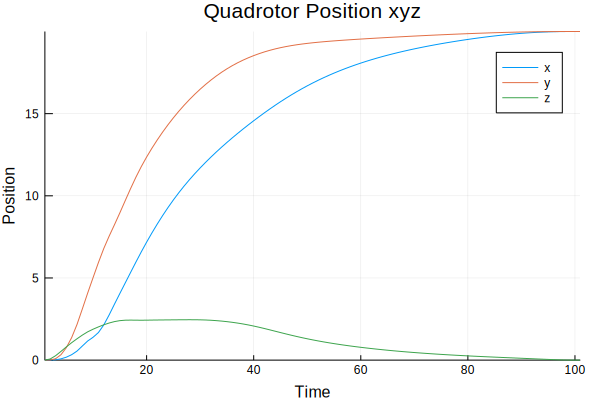

In [24]:
# Position
# plot(results.X[1:3,:]',title="Quadrotor Position xyz",xlabel="Time",ylabel="Position",label=["x";"y";"z"])
plot(results_euler.X[1:3,:]',title="Quadrotor Position xyz",xlabel="Time",ylabel="Position",label=["x";"y";"z"])

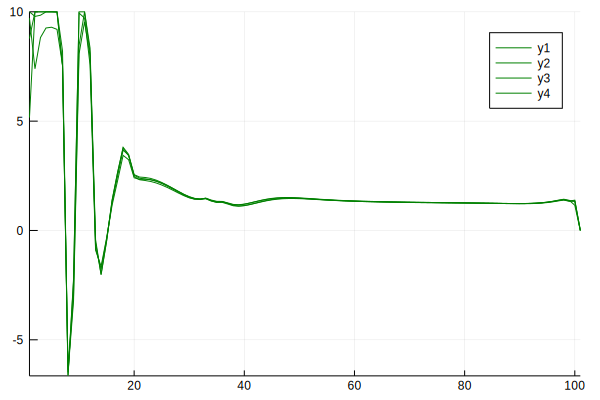

In [25]:
# Control
# plot(results.U[1:m,:]',color="green")
plot(results_euler.U[1:m,:]',color="green")

Quaternion Animation

In [26]:
# ### Visualizer using MeshCat and GeometryTypes ###
# # Set up visualizer
# vis = Visualizer()
# open(vis)

# # Import quadrotor obj file
# urdf_folder = joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf")
# # urdf = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor.urdf")
# obj = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor_base.obj")

# # color options
# green = MeshPhongMaterial(color=RGBA(0, 1, 0, 1.0))
# red = MeshPhongMaterial(color=RGBA(1, 0, 0, 1.0))
# blue = MeshPhongMaterial(color=RGBA(0, 0, 1, 1.0))
# orange = MeshPhongMaterial(color=RGBA(233/255, 164/255, 16/255, 1.0))
# black = MeshPhongMaterial(color=RGBA(0, 0, 0, 1.0))
# black_transparent = MeshPhongMaterial(color=RGBA(0, 0, 0, 0.1))

# # geometries
# robot_obj = load(obj)
# sphere_small = HyperSphere(Point3f0(0), convert(Float32,0.1*quad_radius)) # trajectory points
# sphere_medium = HyperSphere(Point3f0(0), convert(Float32,quad_radius))

# obstacles = vis["obs"]
# traj = vis["traj"]
# target = vis["target"]
# robot = vis["robot"]

# # Set camera location
# settransform!(vis["/Cameras/default"], compose(Translation(25., -5., 10),LinearMap(RotZ(-pi/4))))

# # Create and place obstacles
# for i = 1:n_spheres
#     setobject!(vis["obs"]["s$i"],HyperSphere(Point3f0(0), convert(Float32,spheres[4][i])),red)
#     settransform!(vis["obs"]["s$i"], Translation(spheres[1][i], spheres[2][i], spheres[3][i]))
# end

# # Create and place trajectory
# for i = 1:solver.N
#     setobject!(vis["traj"]["t$i"],sphere_small,blue)
#     settransform!(vis["traj"]["t$i"], Translation(results.X[1,i], results.X[2,i], results.X[3,i]))
# end

# # Create and place initial position
# setobject!(vis["robot"]["ball"],sphere_medium,black_transparent)
# setobject!(vis["robot"]["quad"],robot_obj,black)
# settransform!(vis["robot"],compose(Translation(results.X[1,1], results.X[2,1], results.X[3,1]),LinearMap(quat2rot(results.X[4:7,1]))))

In [27]:
# # Animate quadrotor
# for i = 1:solver.N
#     settransform!(vis["robot"], compose(Translation(results.X[1,i], results.X[2,i], results.X[3,i]),LinearMap(quat2rot(results.X[4:7,i]))))
#     sleep(solver.dt/2)
# end

Euler Angle Animation

In [34]:
### Visualizer using MeshCat and GeometryTypes ###
# Set up visualizer
vis = Visualizer()
open(vis)

Listening on 0.0.0.0:8702...
Could not open browser automatically: could not spawn `start http://127.0.0.1:8702`: no such file or directory (ENOENT)
Please open the following URL in your browser:
http://127.0.0.1:8702


INFO: Serving MeshCat visualizer at http://127.0.0.1:8702


In [35]:
# Import quadrotor obj file
urdf_folder = joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf")
# urdf = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor.urdf")
obj = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor_base.obj")

# color options
green = MeshPhongMaterial(color=RGBA(0, 1, 0, 1.0))
red = MeshPhongMaterial(color=RGBA(1, 0, 0, 1.0))
blue = MeshPhongMaterial(color=RGBA(0, 0, 1, 1.0))
orange = MeshPhongMaterial(color=RGBA(233/255, 164/255, 16/255, 1.0))
black = MeshPhongMaterial(color=RGBA(0, 0, 0, 1.0))
black_transparent = MeshPhongMaterial(color=RGBA(0, 0, 0, 0.1))

# geometries
robot_obj = load(obj)
sphere_small = HyperSphere(Point3f0(0), convert(Float32,0.1*quad_radius)) # trajectory points
sphere_medium = HyperSphere(Point3f0(0), convert(Float32,quad_radius))

obstacles = vis["obs"]
traj = vis["traj"]
target = vis["target"]
robot = vis["robot"]

# Set camera location
# settransform!(vis["/Cameras/default"], compose(Translation(25., -5., 10),LinearMap(RotZ(-pi/4))))

# Create and place obstacles
for i = 1:n_spheres
    setobject!(vis["obs"]["s$i"],HyperSphere(Point3f0(0), convert(Float32,spheres[4][i])),red)
    settransform!(vis["obs"]["s$i"], Translation(spheres[1][i], spheres[2][i], spheres[3][i]))
end

# Create and place trajectory
for i = 1:solver.N
    setobject!(vis["traj"]["t$i"],sphere_small,blue)
    settransform!(vis["traj"]["t$i"], Translation(results_euler.X[1,i], results_euler.X[2,i], results_euler.X[3,i]))
end

Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")

In [38]:
# Create and place initial position
setobject!(vis["robot"]["ball"],sphere_medium,black_transparent)
setobject!(vis["robot"]["quad"],robot_obj,black)
settransform!(vis["robot"],compose(Translation(results_euler.X[1,1], results_euler.X[2,1], results_euler.X[3,1]),LinearMap(quat2rot(eul2quat(results_euler.X[4:7,1])))))

MeshCat Visualizer with path /meshcat/robot

In [39]:
# # Animate quadrotor
# for i = 1:solver.N
#     settransform!(vis["robot"], compose(Translation(results_euler.X[1,i], results_euler.X[2,i], results_euler.X[3,i]),LinearMap(quat2rot(eul2quat(results_euler.X[4:7,i])))))
#     sleep(solver_euler.dt)
# end

# -unconstrained version
for i = 1:solver.N
    settransform!(vis["robot"], compose(Translation(results_uncon_euler.X[1,i], results_uncon_euler.X[2,i], results_uncon_euler.X[3,i]),LinearMap(quat2rot(eul2quat(results_uncon_euler.X[4:7,i])))))
    sleep(solver_euler.dt)
end

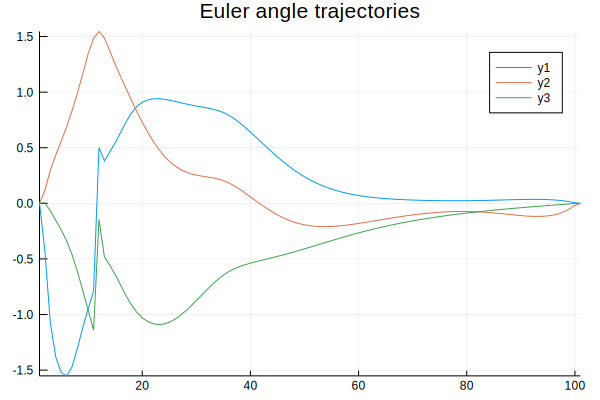

In [40]:
# Plot Euler angle trajectories
eul = zeros(3,solver.N)
for i = 1:solver.N
#     eul[:,i] = TrajectoryOptimization.quat2eul(results.X[4:7,i])
    eul[:,i] = results_euler.X[4:6,i]

end

plot(eul',title=("Euler angle trajectories"))
